<a href="https://colab.research.google.com/github/ivolake/2021sem9_ml_labs/blob/main/CGZ_LW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://slides.com/romvano/lab4/fullscreen

In [1]:
1+1

2

In [57]:
from collections import Counter
import pickle
import operator as op

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.core.pylabtools import figsize
import plotly.express as px
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.offline import iplot, init_notebook_mode

# figsize(8, 8) # зададим размер картинки
init_notebook_mode(connected=True)
pio.renderers.default='notebook'


from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, ShuffleSplit, StratifiedShuffleSplit, LeaveOneOut, cross_val_score
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
# from sklearn.linear_model import SGDClassifier
# from sklearn.svm import SVC
# from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, \
                            precision_score, recall_score, \
                            precision_recall_curve, roc_auc_score, f1_score, \
                            fbeta_score, auc, \
                            make_scorer

from ipywidgets import Image
from io import StringIO
import pydotplus
from sklearn.tree import export_graphviz

# import os
# from glob import glob

from google.colab import drive


In [4]:
drive.mount ('/content/drive')


Mounted at /content/drive


In [5]:
# установим некоторые пакеты, которые понадобятся для удобного отображения дерева
# чтобы следующий код заработал на винде, нужно установить программулину:
# https://graphviz.gitlab.io/_pages/Download/Download_windows.html

import os
if os.name == 'mac':
    !xcode-select --install
    !/usr/bin/ruby -e "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/install)"
    !brew install graphviz

!pip install graphviz
if os.name == 'nt':
    os.environ['PATH'] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin'

!pip install pydotplus

Импорт библиотек, подключение диска

In [8]:
my_path = '/content/drive/MyDrive/drive' # '/content/drive/MyDrive/data'

In [9]:
df = pd.read_csv(f'{my_path}/voice.csv')

In [10]:
df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,0.000000,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,0.000000,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,0.000000,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,0.083878,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,0.104261,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [11]:
df['label'].value_counts()

male      1584
female    1584
Name: label, dtype: int64

In [12]:
feats = list(set(df.columns) - set(['label']))

Обычное разбиение выборок

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df[feats], 
                                                    df['label'], 
                                                    test_size=0.33, 
                                                    random_state=42,
                                                    stratify=df['label'])

## Убедиться в нестабильности одиночного дерева на своих данных

In [7]:
# f1_scorer = make_scorer(fbeta_score, beta=1, greater_is_better = True, pos_label='male')

In [14]:
estimator = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

In [15]:
# pipeline = make_pipeline(
#     # FunctionTransformer(dropper, validate=False),                 # добавили удаление признаков в пайплайн;
#     MinMaxScaler(),
#     estimator
# )
# pipeline

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=3,
                                        random_state=42))])

In [ ]:
labels = {'female': 0, 'male': 1}

In [42]:
# Качества дерева на обучении
# scoring = cross_val_score(estimator=pipeline, 
#                           X=X_train, 
#                           y=y_train, 
#                           scoring=f1_scorer, )
#                           # cv=sss)
# scoring.mean()
estimator.fit(X_train, y_train)
predictions1 = estimator.predict(X_train)
print(f1_score([labels[e] for e in predictions1], [labels[e] for e in y_train]))

0.9619181946403386


In [21]:
# используем .dot формат для визуализации дерева
dot_data = StringIO()
export_graphviz(estimator, feature_names=X_train.columns, # pipeline.steps[1][1]
                out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(value=graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x05\xa3\x00\x00\x01\xf1\x08\x06\x00\x00\x00p\n\xa0\x…

Смотрим на тестовые данные

In [43]:
predictions2 = estimator.predict(X_test)
print(f1_score([labels[e] for e in predictions2], [labels[e] for e in y_test]))

0.9653846153846154


Немного обфусцируем данные с помощью PCA, чтобы более наглядно убедиться в нестабильности дерева

In [44]:
pca = PCA(n_components=2)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

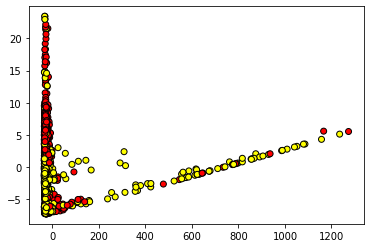

In [48]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train.map(labels), cmap='autumn', edgecolors='black');

Как можно заметить, разделить классы на двух главных компонентах сложно 

In [50]:
def get_grid(data, eps=0.01):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, eps),
                         np.arange(y_min, y_max, eps))

In [54]:
estimator_on_pca = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42).fit(X_train_pca, y_train)


In [ ]:
# xx, yy = get_grid(X_train_pca, eps=.05)
# predicted = estimator_on_pca.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
# plt.pcolormesh(xx, yy, predicted, cmap='autumn')
# plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train.map(labels), s=100, 
#             cmap='autumn', edgecolors='black', linewidth=1.5)
# # plt.title('Easy task. Decision tree compexifies everything');

In [55]:
predictions1 = estimator_on_pca.predict(X_train_pca)
print(f1_score([labels[e] for e in predictions1], [labels[e] for e in y_train]))

0.614207650273224


In [56]:
predictions2 = estimator_on_pca.predict(X_test_pca)
print(f1_score([labels[e] for e in predictions2], [labels[e] for e in y_test]))

0.5760000000000001


## Отобрать самые важные признаки случайным лесом, сравнить результат с отбором признаков линейным методом с L_1-регуляризацией

In [ ]:
RandomForestClassifier(n_estimators=100, 
                       criterion='gini', 
                       max_depth=None, 
                       min_samples_split=2, 
                       min_samples_leaf=1)

## Сравнить качество работы случайного леса без кросс-валидации с кросс-валидацией

# Сравнить качество работы и время обучения  (%%time в начале ячейки) леса с градиентным бустингом над решающими деревьями, при подобрав для каждого оптимальные параметры. Особо хорошо будет, если градиентный бустинг обучите на видеокарте

Создание стратегии кросс-валидации: стратифицированная с перемешиванием

In [ ]:
sss = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2)
# train_test_indicies = []
# for train_indices, test_indices in sss.split(df[feats], df['label']):
#     train_test_indicies.append({'train_indices': train_indices, 
#                                 'test_indices': test_indices})